# SABR Model Test Code

**Name**: 王宇藤 WANG YUTENG 

**Student ID**: 2301212390

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import imp
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import option_models as opt
import random
import time
import pandas as pd

np.set_printoptions(precision=3)

C:\Users\20192\AppData\Local\Temp\ipykernel_34932\821799321.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


## 1. Pricing using Hagan's formula (provided)

### (1) SABR for $0<\beta\le 1$

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 1
vov = 0.5
rho = 0.25
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
# sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([0.204, 0.203, 0.202, 0.201, 0.2  , 0.2  , 0.2  , 0.2  , 0.201,
        0.202, 0.203, 0.204, 0.205, 0.206, 0.208, 0.21 , 0.211, 0.213,
        0.215, 0.217, 0.219, 0.221, 0.223, 0.225, 0.227]))

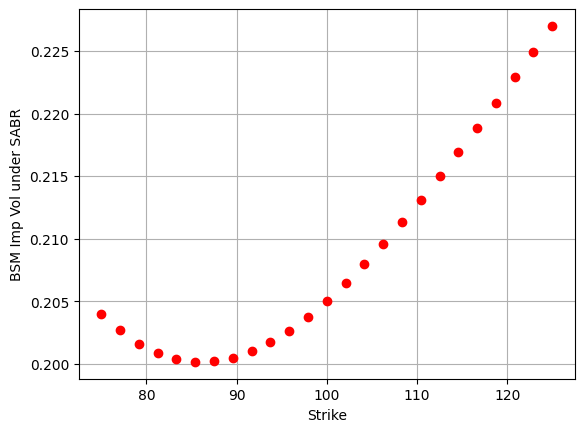

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (2) SABR for $\beta=0$

In [7]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 1
alpha = 0.5
rho = -0.25

In [8]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

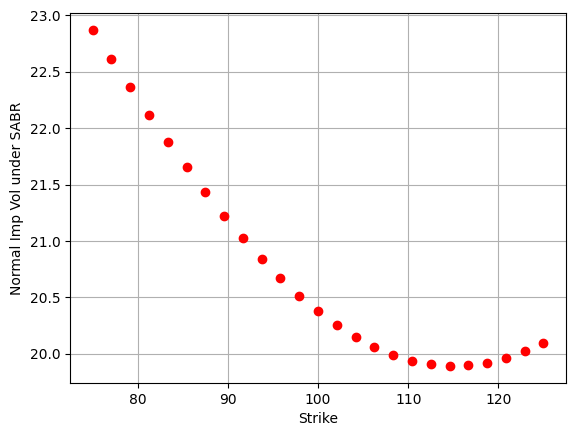

In [9]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (3) Smile calibration to 3 options

In [10]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([13.608,  8.165,  4.769]), array([0.201, 0.205, 0.213]))

In [11]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': 0.25,
 'beta': 1}

In [12]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.2000000000001008,
 'vov': 0.49999999986727106,
 'rho': 0.2499999999825857}

In [13]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.20000000000010157,
 'vov': 0.49999999986712995,
 'rho': 0.24999999998256023}

## 2. Pricing under MC method

In [14]:
strike = np.linspace(75,125,num=25)
forward = 100

In [15]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [16]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.837, 23.956, 22.128, 20.364, 18.674, 17.061, 15.528, 14.082,
        12.73 , 11.475, 10.319,  9.256,  8.288,  7.413,  6.626,  5.922,
         5.289,  4.723,  4.217,  3.767,  3.365,  3.007,  2.687,  2.402,
         2.152]))

Repeat the same for beta = 0

In [17]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [18]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.635, 24.794, 22.992, 21.23 , 19.514, 17.853, 16.249, 14.704,
        13.23 , 11.835, 10.524,  9.303,  8.166,  7.122,  6.164,  5.294,
         4.511,  3.814,  3.198,  2.664,  2.204,  1.815,  1.486,  1.212,
         0.986]))

## 3. Pricing under conditional MC method

In [19]:
strike = np.linspace(75,125,num=25)
forward = 100

In [20]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [21]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.631, 23.752, 21.925, 20.161, 18.467, 16.852, 15.323, 13.886,
        12.544, 11.301, 10.157,  9.11 ,  8.157,  7.295,  6.518,  5.821,
         5.197,  4.64 ,  4.145,  3.704,  3.313,  2.966,  2.658,  2.385,
         2.142]))

Repeat the same for beta = 0

In [22]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [23]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)
    
# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.205, 24.347, 22.529, 20.757, 19.036, 17.374, 15.776, 14.25 ,
        12.802, 11.437, 10.16 ,  8.974,  7.882,  6.885,  5.983,  5.172,
         4.449,  3.811,  3.251,  2.763,  2.341,  1.978,  1.667,  1.402,
         1.177]))

## Compare the MC variance between brute-force MC and conditional MC
For this, you should not use the random number seed

repeat 100 times and compare mean and dev

**Conclusion**:

The following simulation and the result plots shows that:
- Comparing to brute-force MC method, conditional MC method costs less time, takes less computation.
- The mean price of the two methods are almost same.
- Comparing to brute-force MC method, the price of conditional MC has smaller variance, which means the result is more stable.

### a.Comparison between ModelBsmMC and ModelBsmCondMC

In [34]:
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
strike = np.linspace(75,125,num=25)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [35]:
repeat = 100
len = strike.shape[0]
res1, res2 = np.ones((repeat, len)), np.ones((repeat, len))

start1 = time.time()
for t in range(repeat):
    res1[t,:] = sabr_bsm_mc.price(strike, forward, texp)

end1, start2 = time.time(), time.time()
for t in range(repeat):
    res2[t,:] = sabr_bsm_cmc.price(strike, forward, texp)
end2 = time.time()

print('Run time for brute-force MC for BSM Model is ', round(end1 - start1, 2), ' s.\n',
      'Run time for conditional MC for BSM Model is ', round(end2 - start2, 2), ' s.', sep = '')

Run time for brute-force MC for BSM Model is 16.1 s.
Run time for conditional MC for BSM Model is 1.49 s.


In [36]:
df_bsm = pd.DataFrame({
    'strike': strike,
    'mean of ModelBsmMC':res1.mean(axis = 0),
    'std of ModelBsmMC': res1.std(axis = 0),
    'mean of ModelBsmCondMC': res2.mean(axis = 0),
    'std of ModelBsmCondMC': res2.std(axis = 0)
})
df_bsm.set_index('strike', inplace = True)

Text(0.5, 0, 'Strike')

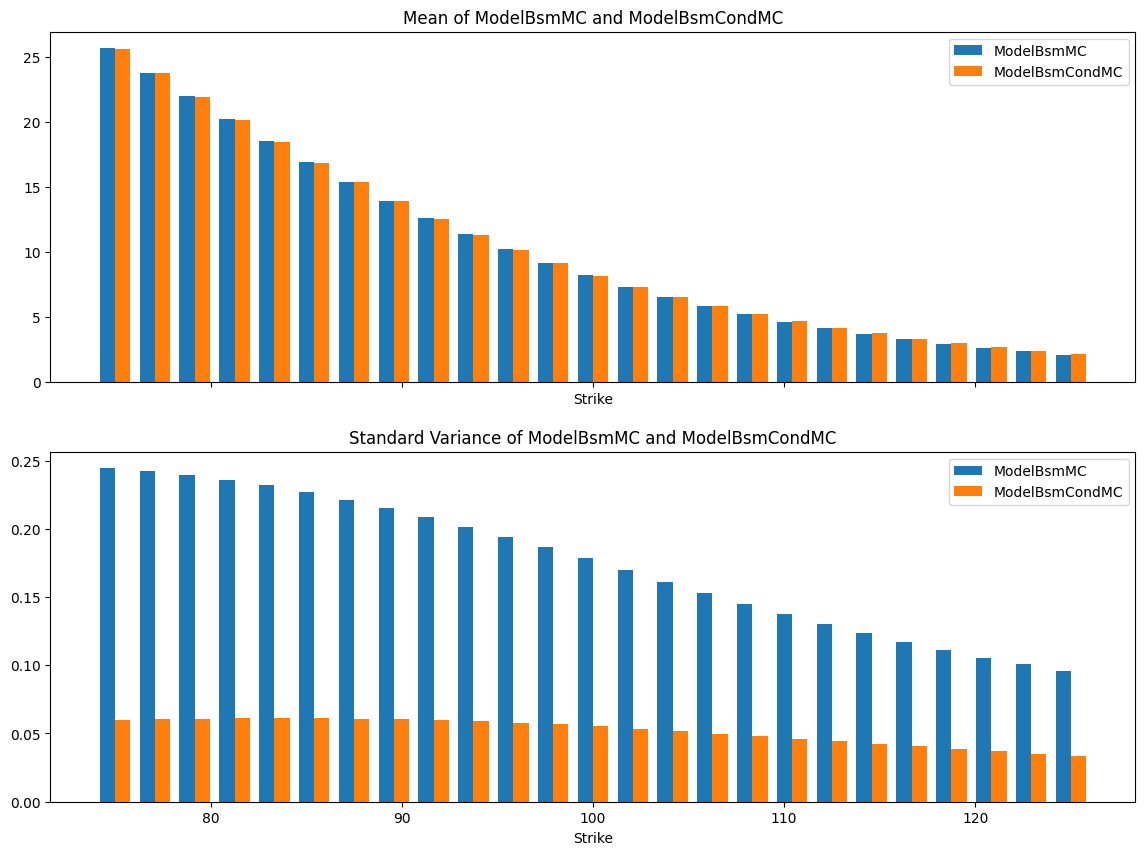

In [39]:
x = np.arange(len)
total_width, n = 1.6, 2 
width = total_width / n  
x1 = strike - width / 2  
x2 = x1 + width   

fig, ax = plt.subplots(2, 1, sharex = True, figsize=(14, 10))
ax[0].bar(x1, df_bsm['mean of ModelBsmMC'], label = 'ModelBsmMC')
ax[0].bar(x2, df_bsm['mean of ModelBsmCondMC'], label = 'ModelBsmCondMC')
ax[0].legend()
ax[0].set_title('Mean of ModelBsmMC and ModelBsmCondMC')
ax[0].set_xlabel('Strike')

ax[1].bar(x1, df_bsm['std of ModelBsmMC'], label = 'ModelBsmMC')
ax[1].bar(x2, df_bsm['std of ModelBsmCondMC'], label = 'ModelBsmCondMC')
ax[1].legend()
ax[1].set_title('Standard Variance of ModelBsmMC and ModelBsmCondMC')
ax[1].set_xlabel('Strike')

### b.Comparison between ModelNormalMC and ModelNormalCondMC

In [40]:
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
strike = np.linspace(75,125,num=25)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [41]:
repeat = 100
len = strike.shape[0]
res3, res4 = np.ones((repeat, len)), np.ones((repeat, len))

start3 = time.time()
for t in range(repeat):
    res3[t,:] = sabr_norm_mc.price(strike, forward, texp)

end3, start4 = time.time(), time.time()
for t in range(repeat):
    res4[t,:] = sabr_norm_cmc.price(strike, forward, texp)
end4 = time.time()

print('Run time for brute-force MC for BSM Model is ', round(end3 - start3, 2), ' s.\n',
      'Run time for conditional MC for BSM Model is ', round(end4 - start4, 2), ' s.', sep = '')

Run time for brute-force MC for BSM Model is 11.93 s.
Run time for conditional MC for BSM Model is 1.2 s.


In [42]:
df_norm = pd.DataFrame({
    'strike': strike,
    'mean of ModelNormalMC':res3.mean(axis = 0),
    'std of ModelNormalMC': res3.std(axis = 0),
    'mean of ModelNormalCondMC': res4.mean(axis = 0),
    'std of ModelNormalCondMC': res4.std(axis = 0)
})
df_norm.set_index('strike', inplace = True)

Text(0.5, 0, 'Strike')

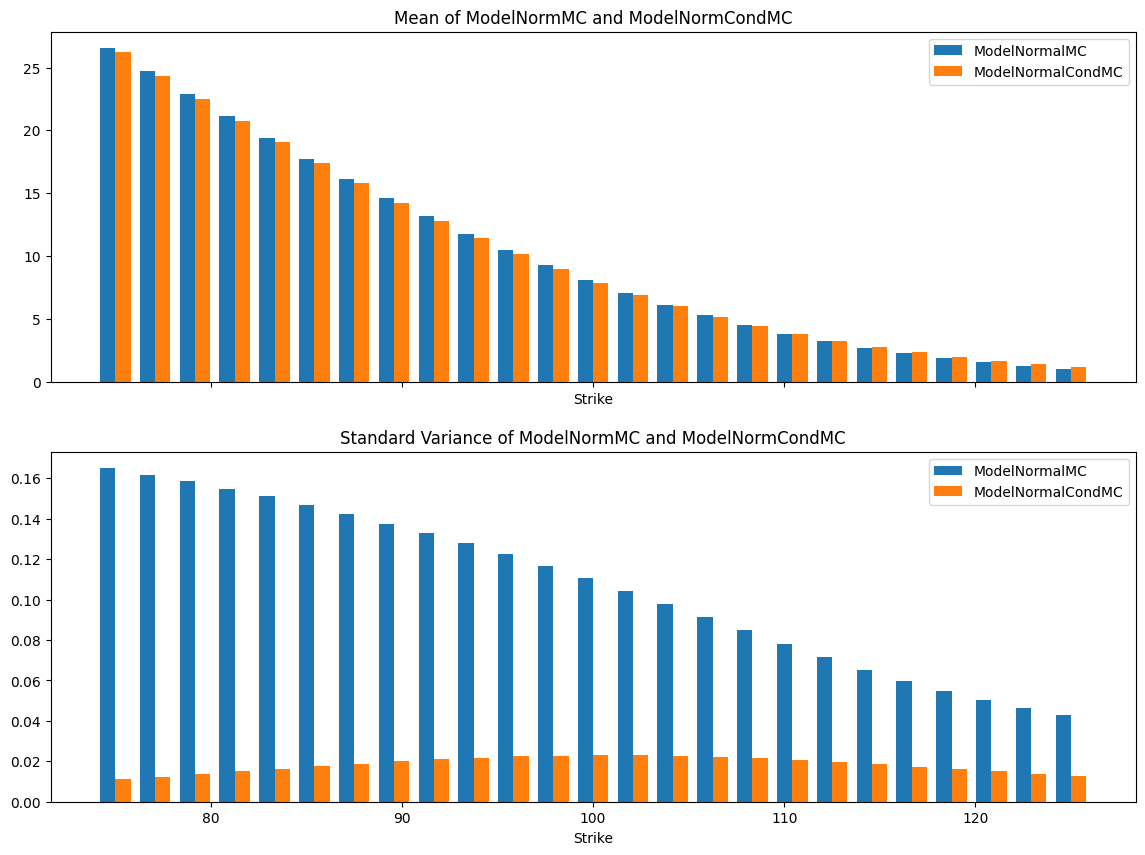

In [44]:
x = np.arange(len)
total_width, n = 1.6, 2 
width = total_width / n  
x3 = strike - width / 2  
x4 = x3 + width   

fig, ax = plt.subplots(2, 1, sharex = True, figsize=(14, 10))
ax[0].bar(x3, df_norm['mean of ModelNormalMC'], label = 'ModelNormalMC')
ax[0].bar(x4, df_norm['mean of ModelNormalCondMC'], label = 'ModelNormalCondMC')
ax[0].legend()
ax[0].set_title('Mean of ModelNormMC and ModelNormCondMC')
ax[0].set_xlabel('Strike')

ax[1].bar(x3, df_norm['std of ModelNormalMC'], label = 'ModelNormalMC')
ax[1].bar(x4, df_norm['std of ModelNormalCondMC'], label = 'ModelNormalCondMC')
ax[1].legend()
ax[1].set_title('Standard Variance of ModelNormMC and ModelNormCondMC')
ax[1].set_xlabel('Strike')